# T036 · Uncertainty estimation

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Michael Backenköhler, 2022, [Volkamer lab](https://volkarmerlab.org), Saarland University

*The examples used in this talktorial template are taken from [__Talktorial T001__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T001_query_chembl/talktorial.ipynb) and [__Talktorial T002__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T002_compound_adme/talktorial.ipynb).*

## Aim of this talktorial

Add a short summary of this talktorial's content.

### Contents in *Theory*

_Add Table of Contents (TOC) for Theory section._

* ChEMBL database
* Compound activity measures

### Contents in *Practical*

_Add Table of Contents (TOC) for Practical section._

* Connect to ChEMBL database
* Load and draw molecules

<div class="alert alert-block alert-info">

<b>Sync TOC with section titles</b>: These points should refer to the headlines of your <i>Practical</i> section.

</div>

### References

* Paper 
* [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb)
* Other useful resources

*We suggest the following citation style:*
* Keyword describing resource: <i>Journal</i> (year), <b>volume</b>, pages (link to resource) 

*Example:*
* ChEMBL web services: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 

## Theory

### Aleatoric uncertainty

### Epistemic uncertainty

### Confidence curves and calibration

## Practical

Add short summary of what will be done in this practical section.

<div class="alert alert-block alert-info">

<b>Sync section titles with TOC</b>: Please make sure that all section titles in the <i>Practical</i> section are synced with the bullet point list provided in the <i>Aim of this talktorial</i> > <i>Contents in Practical</i> section.

</div>

<div class="alert alert-block alert-info">
    
<b>Beware of section levels</b>: Please check if you are using the correct subsection levels. The section <i>Practical</i> is written in Markdown as <code>## Practical</code>, so every subsection within <i>Practical</i> is <code>###</code> or lower.

</div>

In [44]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

import tensorflow as tf

from t022 import neural_network_model, smiles_to_fp, load_chembl_egfr_data

%matplotlib inline

<div class="alert alert-block alert-info">

<b>Imports</b>: Please add all your imports on top of this section, ordered by standard library / 3rd party packages / our own (<code>teachopencadd.*</code>). 
Read more on imports and import order in the <a href="https://www.python.org/dev/peps/pep-0008/#imports">"PEP 8 -- Style Guide for Python Code"</a>.
    
</div>

In [ ]:
import tqdm

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

<div class="alert alert-block alert-info">

<b>Relative paths</b>: Please define all paths relative to this talktorial's path by using the global variable <code>HERE</code>.
If your talktorial has input/output data, please define the global <code>DATA</code>, which points to this talktorial's data folder (check out the default folder structure of each talktorial).
    
</div>

### Connect to ChEMBL database

Load data.

In [20]:
chembl_df = load_chembl_egfr_data(DATA / "CHEMBL25_activities_EGFR.csv", method='morgan3', n_bits=1024)
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)
x_test = tf.convert_to_tensor(np.array([np.array(a, dtype=int) for a in x_test], dtype=int))

We now set up the pipeline of creating and training a model.

In [35]:
def create_and_fit_model(layers=[512, 128, 64], **kwargs):
    """
    Create and fit an instance of a feed-forward neural network (see Talktorial 022).
    
    Parameters
    ----------
    layers: List[int]
        The width of hidden layers in the feed-forward neural net.
    
    **kwargs
        The keyword arguments are passed to the `model.fit` function.
    
    Returns
    -------
    Sequential
        A fitted feed-forward NN.
    """
    model = neural_network_model(layers)
    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        **kwargs,
    )
    
    return model

In [42]:
ensemble = [create_and_fit_model(verbose=0, batch_size=64, epochs=30) for _ in tqdm.tqdm(range(100))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [26:40<00:00, 16.00s/it]


In [78]:
scores = np.array([model.predict(x_test) for model in tqdm.tqdm(ensemble)])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


In [84]:
scores = np.array(scores)

In [180]:
stds = scores.std(0).flatten()
mean = scores.mean(0).flatten()
mae = np.abs(mean - y_test.values.flatten()).flatten()

Text(0, 0.5, 'MAE')

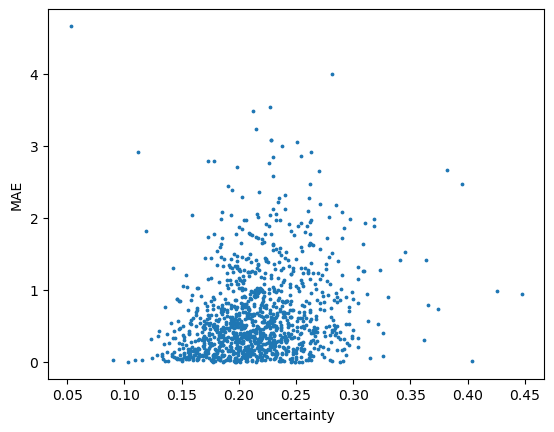

In [182]:
plt.scatter(stds, mae, s=3)
plt.xlabel('uncertainty')
plt.ylabel('MAE')
# plt.yscale('log')
# plt.xscale('log')

In [183]:
from scipy.stats import norm

In [233]:
confidences = np.linspace(.0, 1)

In [234]:
hits = []
for c in confidences:
    delta = stds * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble))
    a = (mean - delta < y_test.values.flatten()) & (mean + delta > y_test.values.flatten()).astype(int)
    hits.append(a.sum() / len(a))

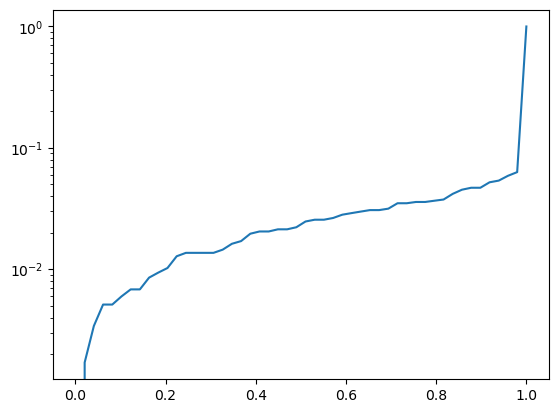

In [236]:
plt.plot(confidences, hits)
plt.yscale('log')

In [223]:
arr.sum()

83

<div class="alert alert-block alert-info">

<b>Functions</b>: 

<ul>
<li>Please add <a href="https://numpydoc.readthedocs.io/en/latest/format.html">numpy docstrings</a> to your functions.</li>
<li>Please expose all variables used within a function in the function's signature (i.e. they must be function parameters), unless they are created within the scope of the function.</li>
<li>Please add comments to the steps performed in the function.</li>
<li>Please use meaningful function and parameter names. This applies also to variable names.</li>
</ul>
    
</div>

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>